In [1]:
from expkit import ExpSetup
from expkit.ops import (
    EvalMean,
    EvalLast,
    EvalMax,
    EvalTotalMean,
    EvalMeanLast,
    EvalMeanMax,
    Operation,
    proj,
    OperationType,
)
from functools import partial
import numpy as np
# beta in used by the rlhf model: 0.0325
N = 1024
TEMP = 0.6
n=128
N_MEASURAMENTS=[1,2,4,8,16,32,64,128]
eval_key = "qe:Unbabel-XCOMET-XL"
LP ="is-en"

In [2]:
setup = ExpSetup(
    "/gscratch/ark/graf/quest-rlhf/mt-outputs/",
    lazy=True,
    load_instances=False,
    ops={
        "diversity": Operation(
            type=OperationType.EVAL,
            func=lambda instance_evals: 1-np.mean(list(
                map(
                    lambda x:  np.array(
                        x["scores"]
                    ).sum()/((len(x["scores"])-1)*len(x["scores"])) if len(x["scores"]) >1 else 1,
                    instance_evals,
                )
            )),
            key="pairwise-bleu_repr",
        ),
        **{
            f"mean-reward-{n}": EvalTotalMean(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
        **{
            f"last-reward-{n}": EvalMeanLast(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
        **{
            f"max-reward-{n}": EvalMeanMax(
                entry_key="scores",
                eval_key=eval_key,
                n=n,
            )
            for n in N_MEASURAMENTS
        },
    },
).query(
    {"steps": 128}
)

In [3]:
setup=setup.query({"language_pair": LP})

In [4]:
for exp in setup:
    print(exp.name)
    print(exp.evals.keys())
    print(exp.meta)
    print("--"*40)

fdf9d90f-2acd-4371-8286-4135451dfc77
dict_keys(['pairwise-bleu', 'qe:Unbabel-XCOMET-XL', 'qe:Unbabel-wmt23-cometkiwi-da-xl'])
{'beta': 0.01, 'steps': 128, 'temperature': 0.8, 'model_path': 'haoranxu/ALMA-7B', 'reward_model_path': 'Unbabel/wmt23-cometkiwi-da-xl', 'variant': 'quest', 'reward_type': 'contextual', 'stop_tokens': [], 'index': 'uniform', 'max_new_tokens': 800, 'max_prompt_length': 1200, 'at': '2024-08-04T19:32:35.752654', 'language_pair': 'is-en', 'llm': 'alma'}
--------------------------------------------------------------------------------
2a02d766-ffbf-4070-a489-1babc318eeab
dict_keys(['pairwise-bleu', 'qe:Unbabel-XCOMET-XL', 'correctedqe:Unbabel-XCOMET-XL', 'qe:Unbabel-wmt23-cometkiwi-da-xl'])
{'beta': 1.0, 'steps': 128, 'temperature': 0.8, 'model_path': 'haoranxu/ALMA-7B', 'reward_model_path': 'Unbabel/wmt23-cometkiwi-da-xl', 'variant': 'quest', 'reward_type': 'contextual', 'stop_tokens': [], 'index': 'uniform', 'max_new_tokens': 800, 'max_prompt_length': 1200, 'at': '2

In [5]:
base = setup.query(
    {
        "variant": "ancestral"#,"temperature":0.8
    }
)

quest = setup.query({"variant": "quest"})


print("---" * 20)
print(LP)
print("base")
print(
    len(
        base.meta()
    )
)
print(
    list(map(
        proj("temperature"),
        base.meta()
    ))
)
print("quest")
print(
    len(
        quest.meta()
    )
)
print(
    list(map(
        proj("beta"),
        quest.meta(),
    ))
)

------------------------------------------------------------
is-en
base
3
[0.5, 0.8, 0.1]
quest
3
[0.01, 1.0, 0.1]


In [6]:
quest=quest.eager().sort("beta")
quest.run_ops()
for q in quest:
    print(q.evals.keys())
    print(q.meta["beta"])
    print(q.ops_results)

ops-error: 'pairwise-bleu_repr'
ops-error: 'pairwise-bleu_repr'
ops-error: 'pairwise-bleu_repr'


In [7]:
base = base.eager().sort("temperature")
base.run_ops()
for q in base:
    print(q.evals.keys())
    print(q.meta["temperature"])
    print(q.ops_results)

ops-error: 'pairwise-bleu_repr'
ops-error: 'pairwise-bleu_repr'
ops-error: 'pairwise-bleu_repr'


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def plot_graph(
    metric="mean-reward",
    show=True,
    lw="-",
    **baselines,
):
    N = N_MEASURAMENTS

    if show:
        plt.figure(figsize=(10, 5))

    cmap = plt.get_cmap("plasma")

    for k, base in baselines.items():
        BASEvalues = [
            base.get(f"{metric}-{n}")
            for n in N
        ]

        print(k, "--" * 20)
        print(N)
        print(BASEvalues)

        plt.plot(
            N,
            np.round(BASEvalues, 2),
            label=k,
            linestyle=lw,
            # color="black",
        )

    plt.legend()
    plt.ylabel("reward")
    plt.xlabel("n")
    if show:
        plt.title(metric)
        plt.show()

base_BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.9231188265290261, 0.9323897053112984, 0.9390750689737797, 0.9444638513591289, 0.9479338358559609, 0.9507452322204113, 0.9533408939065934, 0.956328689284563]
quest- 0.01-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.8766050814555884, 0.8982525212421417, 0.9155144992607833, 0.9307900776511431, 0.9400263013480902, 0.9470330207659007, 0.9520315041588544, 0.9547195910701752]
quest- 0.1-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.8766050819026232, 0.8883033526792526, 0.9045474551050663, 0.9151632640552521, 0.9210355130021571, 0.9244434280273914, 0.9263755806643963, 0.9276485198905469]
quest- 1.0-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.8766050868051052, 0.8841286996057033, 0.8953249337418079, 0.9044880342817306, 0.9096286214151382, 0.9126386461157799, 0.9148595096836091, 0.915933751802683]


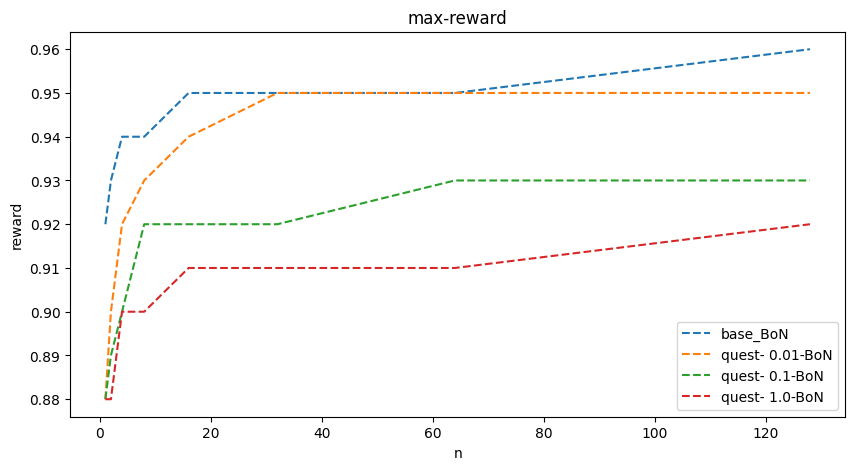

In [16]:
plot_graph(
    base_BoN=base[0],
    #quest_BoN=quest[0],
    #rlhf_BoN=rlhf[0],
    # free_proposal=proposal[0],
    # quest=quest[0],
    # compute_adjusted_quest=quest[0],
    # rlhf=rlhf[0],
    metric="max-reward",
    **{
        f"quest- {e.meta['beta']}-BoN": e
        for e in quest
    },
    show=True,
    lw="--",
)

base_BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.9231188265290261, 0.9234896466073395, 0.9242440048579872, 0.9249036662324667, 0.9246827062904015, 0.9244618334274403, 0.9246287812793925, 0.9246887277746164]
quest- 0.01-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.8766050814555884, 0.8852831943820119, 0.8957688713768721, 0.9061747585769891, 0.914836967671059, 0.9217517760413922, 0.9259987683616839, 0.9287962663435843]
quest- 0.1-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.8766050819026232, 0.8752048134559393, 0.8744707972498238, 0.8701698029586226, 0.8599779881782532, 0.8443617456519082, 0.8184988637733907, 0.7807445118568228]
quest- 1.0-BoN ----------------------------------------
[1, 2, 4, 8, 16, 32, 64, 128]
[0.8766050868051052, 0.8714380251101255, 0.8646239606040418, 0.8516069142553955, 0.832597173207134, 0.8044197249239683, 0.7658633697253483, 0.7145076148637696]


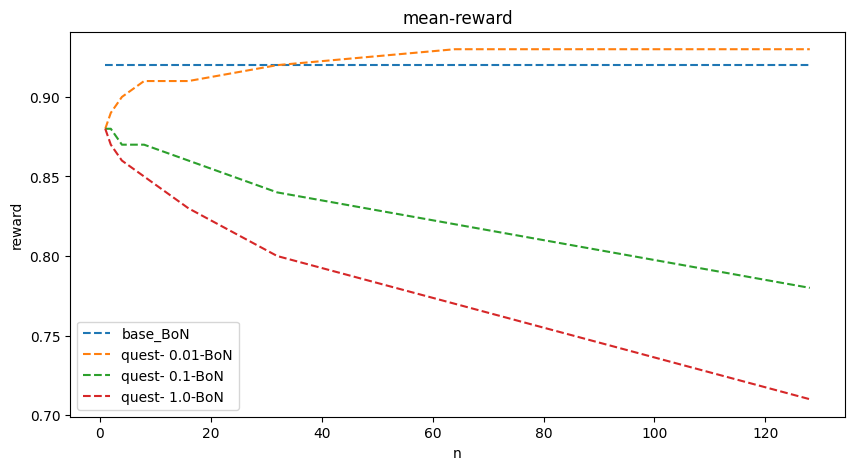

In [17]:
plot_graph(
    base_BoN=base[0],
    # quest_BoN=quest[0],
    # rlhf_BoN=rlhf[0],
    # free_proposal=proposal[0],
    # quest=quest[0],
    # compute_adjusted_quest=quest[0],
    # rlhf=rlhf[0],
    metric="mean-reward",
    **{
        f"quest- {e.meta['beta']}-BoN": e
        for e in quest
    },
    show=True,
    lw="--",
)

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl

sns.set_theme()

# sns.set(rc={"figure.figsize": (15, 10)})
sns.set(font_scale=3)
import numpy as np
import pandas as pd

def plot_pareto_graph(
    comparisons,
    x_name,
    y_name,
    title,
    y_label=None,
    x_label=None,
    xlim=None,
    ylim=None,
):
    plt.figure(figsize=(15, 10))
    plt_data = []
    for (
        method,
        experiments,
    ) in comparisons.items():

        for exp in experiments:
            try:
                
                print(exp.ops_results)
                x = exp.ops_results[
                    x_name
                ]
                y = exp.ops_results[
                    y_name
                ]
                plt_data.append(
                    [
                        method,
                        exp.meta[
                            "temperature"
                        ],
                        x,
                        y,
                    ]
                )
            except Exception as e:
                print(e)
                pass

                # plt_data.append([method + f"-beta{exp.meta.get('beta', '')}", exp.meta["temperature"], x, y])
    plot_df = pd.DataFrame(plt_data)
    
    print(plt_data)
    
    plot_df.columns = [
        "Method",
        "τ",
        x_name,
        y_name,
    ]

    name_dict = {
        #"nucleus": "Nucleus",
        #"beam_sample": "Beam Sample",
        "ancestral": "Ancestral",
        "quest": "QUEST",
        #"mcmc-qe-rlhf": "QUEST-RLHF",
    }
    plot_df["Method"] = plot_df[
        "Method"
    ].apply(lambda x: name_dict[x])
    plot_df = plot_df[
        plot_df.Method.isin(
            [
                "Ancestral",
                "QUEST",
                #"QUEST-RLHF",
            ]
        )
    ]
    plot_df = plot_df.sort_values(
        by=[x_name]
    )

    plot_df["Method"] = pd.Categorical(
        plot_df["Method"],
        categories=[
            "Ancestral",
            "QUEST",
            #"QUEST-RLHF",
        ],
        ordered=True,
    )
    plot_df = plot_df.sort_values(
        by=["Method"]
    )

    plot_df[y_name] = plot_df[y_name] * 100
    plot_df[x_name] = plot_df[x_name] * 100
    # print(plot_df.head())

    ax = sns.scatterplot(
        plot_df,
        x=x_name,
        y=y_name,
        hue="Method",
        legend="brief",
        s=500,
    )
    ax = sns.lineplot(
        plot_df,
        x=x_name,
        y=y_name,
        hue="Method",
        legend=None,
    )

    # for method in plot_df.method.unique():
    #    xqd, yqd = fit_quadratic(plot_df[plot_df["method"]==method][x_name].to_list(), plot_df[plot_df["method"]==method][y_name].to_list())
    #    plt.plot(xqd, yqd)

    # plt.axhline(plot_df[(plot_df.Method=='ancestral') & (plot_df["τ"]==0.8)][y_name].values[0], linestyle="-.", color="black", linewidth=1)
    # plt.axvline(plot_df[(plot_df.Method=='ancestral') & (plot_df["τ"]==0.8)][x_name].values[0], linestyle="-.", color="black", linewidth=1)
    # plt.legend('',frameon=False)
    ax.legend(loc="lower left")

    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel(x_label, fontsize=40)
    plt.ylabel(y_label, fontsize=40)

    # if xlim is not None:
    # plt.xlim(30, 80)

    # if ylim is not None:
    # plt.ylim(65, 90)

    plt.title(title, fontsize=40)
    # plt.show()

    # plt.savefig(file_name)

{'diversity': 0.0, 'mean-reward-1': 0.8766050814555884, 'mean-reward-2': 0.8852831943820119, 'mean-reward-4': 0.8957688713768721, 'mean-reward-8': 0.9061747585769891, 'mean-reward-16': 0.914836967671059, 'mean-reward-32': 0.9217517760413922, 'mean-reward-64': 0.9259987683616839, 'mean-reward-128': 0.9287962663435843, 'last-reward-1': 0.8766050814555884, 'last-reward-2': 0.8939613073084354, 'last-reward-4': 0.9082003694835901, 'last-reward-8': 0.9189620785701275, 'last-reward-16': 0.9257290096765758, 'last-reward-32': 0.9297687310137749, 'last-reward-64': 0.9292605186696052, 'last-reward-128': 0.9324581324642898, 'max-reward-1': 0.8766050814555884, 'max-reward-2': 0.8982525212421417, 'max-reward-4': 0.9155144992607833, 'max-reward-8': 0.9307900776511431, 'max-reward-16': 0.9400263013480902, 'max-reward-32': 0.9470330207659007, 'max-reward-64': 0.9520315041588544, 'max-reward-128': 0.9547195910701752}
{'diversity': 0.0, 'mean-reward-1': 0.8766050819026232, 'mean-reward-2': 0.875204813455

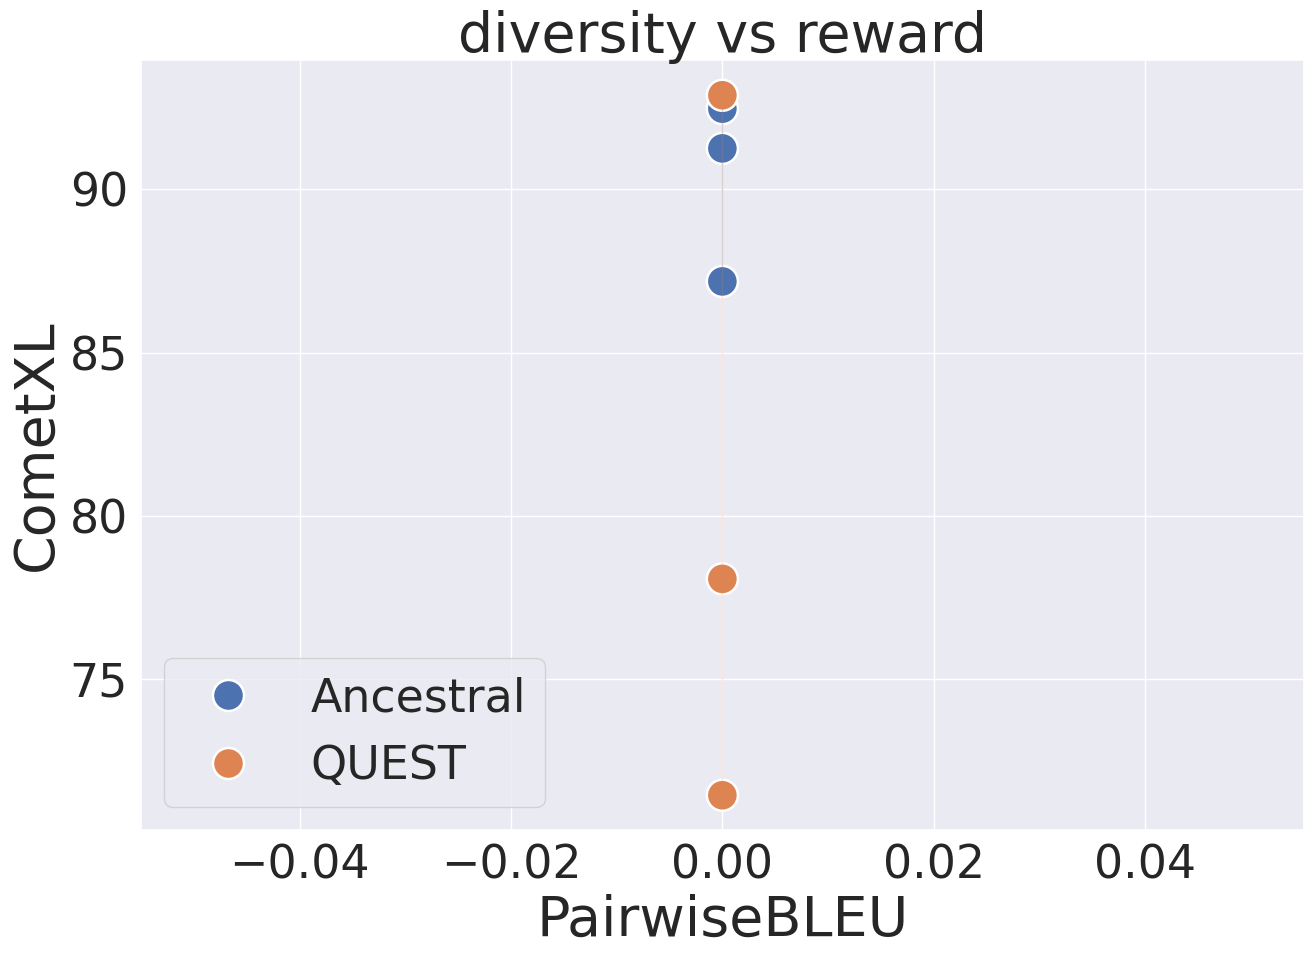

In [19]:
plot_pareto_graph(
    {
     "quest":quest,
     "ancestral":base},
    "diversity",
    "mean-reward-128",
    "diversity vs reward",
    y_label="CometXL",
    x_label="PairwiseBLEU",
    xlim=None,
    ylim=None,
)

In [20]:
quest[0].evals["pairwise-bleu"][0].results["scores"]

[[[0.0,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   1.0,
   1.0,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   1.0,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432,
   0.9188330173492432],
  [0.9031153321266174,
   0.0,
   -4.440892098500626e-16,
   -4.440892098500626e-16,
   -4.440892098500626e-16,
   0.405396431684494,
   0.405396431684494,
   0.8755976557731628,
   0.8755976557731628,
   0.405396431684494,
   0.405396431684494,
   0.405396431684494,
   0.405396431684494,
   0.405396431684494,
   0.405396431684494,
   0.405396431684494,
   0.405396431684494,
   0.680528461933136,
 

In [21]:
b = base[0].refresh(force=True)
q = quest[0].refresh(force=True)

In [22]:
q.instances[0].input_data

{'prompt': 'Translate this from Icelandic to English:\nIcelandic: Hrópað á heiminn\nEnglish:',
 'reference_sentence': 'Screaming at the world',
 'source_sentence': 'Hrópað á heiminn',
 'source_language': 'Icelandic',
 'target_language': 'English'}

In [23]:
uniquesqi = []
uniquesbi = []
for qi,bi in zip(q.instances,b.instances): 
    lst = list(map(proj("text"),qi.outputs))
    snd = list(
        map(proj("text"), bi.outputs)
    )
    
    uniquesqi.append(
        len(set(lst))
    )
    uniquesbi.append(
        len(set(snd))
    )
    # print(lst[40])
    # print(q.evals["qe:Unbabel-XCOMET-XL"][0].results["scores"][40])

print(np.mean(uniquesqi))
print(np.mean(uniquesbi))

9.522
14.455


In [24]:
snd = list(
    map(
        proj("text"), b.instances[1].outputs
    )
)
print(snd[0])
#print(b.evals["qe:Unbabel-XCOMET-XL"][0].results["scores"][0])
print(set(snd))

The "Looks Like You Need Iceland" campaign has been well received and the calls to action in the wild are starting to draw people from all over the world.</s>
{'The campaign Looks Like You Need Iceland has been deemed a success, and the calls to action in the wilds of nature are starting to draw people from all over the world.</s>', 'The "Looks Like You Need Iceland" campaign has been deemed a success, and the calls to action heard in the wilds of Iceland are now being heard around the world.</s>', 'The campaign, Looks Like You Need Iceland, has been hailed as a success, and the calls to action heard around the world are starting to pull in people from all over the world.</s>', 'The campaign Looks Like You Need Iceland has been deemed a success, and the calls to action in the wild are starting to draw people from all over the world.</s>', 'The campaign, Looks Like You Need Iceland, has been well received and the calls to action in the wild have started to draw people from all over the 

In [25]:
def get_reproduce_samples(q):
    return [[o["text"] for o in q.instances[0].outputs if o["accept"] ] for i in q.instances]

reproduce_samples =get_reproduce_samples(q)
#print(set(reproduce_samples))
print(len(reproduce_samples))

# 

1000


In [26]:
set(b.evals["qe:Unbabel-XCOMET-XL"][0].results["scores"])

{0.876561164855957, 0.8837606310844421, 0.988223671913147}

In [27]:
set(
    q.evals["qe:Unbabel-XCOMET-XL"][
        0
    ].results["scores"]
)

{0.7963482141494751,
 0.8596327304840088,
 0.8640736341476442,
 0.882412075996399,
 0.882440447807312,
 0.923823356628418,
 0.9343390464782715}